<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/ventilator_gb_rescaling_eda_V10_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

V1: Keep R/C, improve

V2: Add R**2, no improve

V3: Update model from https://www.kaggle.com/dlaststark/gb-vpp-pulp-fiction. Not much improve compare V1

V4: Use whole db for test Fold-1
Fold-1 | OOF Score: 0.15912771348961205

V5: Add loading ScaleLayer from saved model

V6: Add TransformerEncoder. TransformerEncoder(128, 512, 8, name="transformer_layer")(x). Testing in GPU.

V7: Try to scale targe to 0-1, but it slow the train as MASE cannot be scaled.

V8: Removed target scale.
Epoch 00022: val_loss improved from 0.32912 to 0.30967, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 23/150
127/127 [==============================] - 161s 1s/step - loss: 0.3176 - val_loss: 0.2917

Not Good as without TransformerEncoder. Change paramemter back to 

V8: Change attention result to multiple instead of concate.

Loss is smaller than without LayerNormalization, but CV is bigger. It means it overfit the train data.

TransformerEncoder(128, 512, 8, 0.3, name="transformer_layer")

Epoch 00181: val_loss did not improve from 0.16212
Epoch 182/200
127/127 [==============================] - 163s 1s/step - loss: 0.0448 - val_loss: 0.1655

Epoch 00182: ReduceLROnPlateau reducing learning rate to 5.6313510867767036e-05.

Epoch 00182: val_loss did not improve from 0.16212
Restoring model weights from the end of the best epoch.
Epoch 00182: early stopping
Fold-1 | OOF Score: 0.16211654680482343

V9: Increase attention dropout to 0.6, add 0.01 droupout to input
Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.00031640623637940735.

Epoch 00123: val_loss did not improve from 0.16714
Epoch 124/200
127/127 - 161s - loss: 0.0838 - val_loss: 0.1694

Epoch 00124: val_loss did not improve from 0.16714
Epoch 125/200
127/127 - 161s - loss: 0.0796 - val_loss: 0.1727

V10: add TransformerEncoder to all layer with Multiply



In [1]:
# Update pandas version for Colab TPU
!pip install pandas==1.3.2

## Import libraries

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  from google.colab import drive
  drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [4]:
if IN_COLAB:
  !pip install kaggle
  !mkdir /root/.kaggle
  !cp /gdrive/MyDrive/ventilator-pressure-prediction/kaggle.json /root/.kaggle
  !kaggle competitions download -c ventilator-pressure-prediction
  !mkdir -p ../input/ventilator-pressure-prediction
  !unzip '*.zip' -d ../input/ventilator-pressure-prediction
  !ls ../input/ventilator-pressure-prediction
  !mkdir /gdrive/MyDrive/ventilator-pressure-prediction/gb-rescaling-eda-v3-gpu
  #Map Google driver folder to local folder model to save model
  !ln -s /gdrive/MyDrive/ventilator-pressure-prediction/gb-rescaling-eda-v3-gpu model-gpu
else:
  !mkdir ./model-gpu

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
replace ../input/ventilator-pressure-prediction/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  sample_submission.csv.zip

Archive:  test.csv.zip

3 archives were successfully processed.
sample_submission.csv  test.csv  train.csv
mkdir: cannot create directory ‘/gdrive/MyDrive/ventilator-pressure-prediction/gb-rescaling-eda-v3-gpu’: File exists
ln: failed to create symbolic link 'model-gpu/gb-rescaling-eda-v3-gpu': File exists


In [5]:
import gc
import numpy as np
import pandas as pd
import random
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply



# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything()

## Load datasets

In [6]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
all_pressure = np.sort(train_df['pressure'].unique())
pressure_min =  all_pressure[0].item()
pressure_max = all_pressure[-1].item()
pressure_step = (all_pressure[1] - all_pressure[0]).item()

pressure_min,pressure_max,pressure_step

(-1.895744294564641, 64.8209917386395, 0.07030214545121005)

In [8]:
DEBUG = False

if DEBUG:
    train_df = train_df[:80*10000]

In [9]:
test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [10]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    #df['u_in_diff_1_2'] = df['u_in_lag1'] - df['u_in_lag2']
    #df['u_out_diff_1_2'] = df['u_out_lag1'] - df['u_out_lag2']
    #df['u_in_lagback_diff_1_2'] = df['u_in_lag_back1'] - df['u_in_lag_back2']
    #df['u_out_lagback_diff_1_2'] = df['u_out_lag_back1'] - df['u_out_lag_back2']
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R_cat'] = df['R'].astype(str)
    df['C_cat'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [11]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,cross,cross2,area,time_step_cumsum,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__max,breath_id__u_out__max,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,one,count,u_in_cummean,breath_id_lag,breath_id_lag2,breath_id_lagsame,breath_id_lag2same,breath_id__u_in_lag,breath_id__u_in_lag2,time_step_diff,ewm_u_in_mean,15_in_sum,15_in_min,15_in_max,15_in_mean,u_in_lagback_diff1,u_out_lagback_diff1,u_in_lagback_diff2,u_out_lagback_diff2,R_cat_20,R_cat_5,R_cat_50,C_cat_10,C_cat_20,C_cat_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.0,0.0,0.000000,0.000000,0.083334,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,28.313036,1,28.229702,10.062673,0.083334,0.0,0.083334,0.0,0.083334,0.0,0.083334,0.0,1,1,0.083334,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.083334,0.083334,0.083334,0.083334,0.083334,-18.299707,0.0,-22.425944,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.0,0.0,0.618632,0.033652,18.466375,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,28.313036,1,9.929994,-8.237035,18.299707,0.0,18.383041,0.0,18.383041,0.0,18.383041,0.0,1,2,9.233188,1.0,0.0,1,0,0.083334,0.000000,0.033652,9.585358,18.466375,0.083334,18.383041,9.233188,-4.126236,0.0,-4.425781,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,3,1,20,50,0.067514,22.509278,0,7.876254,0.0,0.0,2.138333,0.101167,40.975653,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,0.000000,0.0,27.127486,0.0,28.313036,1,5.803758,-12.363271,4.126236,0.0,22.425944,0.0,22.509278,0.0,22.509278,0.0,1,3,13.658551,1.0,1.0,1,1,18.383041,0.083334,0.033862,14.229040,40.975653,0.083334,22.509278,13.658551,-0.299544,0.0,-2.846573,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,4,1,20,50,0.101542,22.808822,0,11.742872,0.0,0.0,4.454391,0.202709,63.784476,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,27.127486,0.0,0.000000,0.0,26.807732,0.0,28.313036,1,5.504214,-12.662816,0.299544,0.0,4.425781,0.0,22.725488,0.0,22.808822,0.0,1,4,15.946119,1.0,1.0,1,1,22.509278,18.383041,0.034028,16.627759,63.784476,0.083334,22.808822,15.946119,-2.547028,0.0,-4.451044,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,1,20,50,0.135756,25.355850,0,12.234987,0.0,0.0,7.896588,0.338464,89.140326,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,26.807732,0.0,0.083334,0.0,27.864715,0.0,28.313036,1,2.957185,-15.209844,2.547028,0.0,2.846573,0.0,6.972809,0.0,25.272516,0.0,1,5,17.828065,1.0,1.0,1,1,22.808822,22.509278,0.034213,18.652046,89.140326,0.083334,25.355850,17.828065,-1.904016,0.0,-1.771635,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [12]:
del train_df
del test_df
gc.collect()

117

In [13]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

print(f"train: {train.shape} \ntest: {test.shape}")

train: (6036000, 66) 
test: (4024000, 66)


In [14]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 66) 
test: (50300, 80, 66) 
targets: (75450, 80)


In [15]:
# np.save('train.npy', train)
# np.save('test.npy', test)
# !zip features.zip train.npy test.npy

## Hardware config

In [16]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 256
    print(f"Running on {tpu_strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 256


## Rescaling layer

In [17]:
@tf.custom_gradient
def round_with_gradients(x):
    def grad(dy):
        return dy
    return tf.round(x), grad

class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaleLayer, self).__init__(**kwargs)
        self.min = tf.constant(pressure_min, dtype=np.float32)
        self.max = tf.constant(pressure_max, dtype=np.float32)
        self.step = tf.constant(pressure_step, dtype=np.float32)

    def call(self, inputs):
        steps = tf.math.divide(tf.math.add(inputs, -self.min), self.step)
        int_steps = round_with_gradients(steps)
        rescaled_steps = tf.math.add(tf.math.multiply(int_steps, self.step), self.min)
        clipped = tf.clip_by_value(rescaled_steps, self.min, self.max)
        return clipped
    # def get_config(self):
    #     return super(ScaleLayer, self).get_config()


In [18]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout=0.3, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_dropout = dropout
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation=tf.nn.gelu), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads})
        return config

## Keras DNN Model

In [19]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)

    dropout_r = 0.01
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z31_transformer = TransformerEncoder(384*2, 512*2, 8, dropout_r, name="transformer_layer_z31")(z31)
    z31 = Multiply()([z31, z31_transformer])
    
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z41_transformer = TransformerEncoder(256*2, 384*2, 8, dropout_r, name="transformer_layer_z41")(z41)
    z41 = Multiply()([z41, z41_transformer])
    
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z51_transformer = TransformerEncoder(128*2, 256*2, 8, dropout_r, name="transformer_layer_z51")(z51)
    z51 = Multiply()([z51, z51_transformer])
    
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])

    x = Dense(units=128)(x)

    x_transformer = BatchNormalization()(x)
    x_transformer = TransformerEncoder(128, 512, 8, dropout_r, name="transformer_layer_128")(x_transformer)
    x = Multiply()([Dropout(0.01)(x), x_transformer])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)
    
    x_output = ScaleLayer()(x_output)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [20]:
model = dnn_model()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 66)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 1536)     5130240     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 768)      4328448     bidirectional_1[0][0]            
__________________________________________________________________________________________

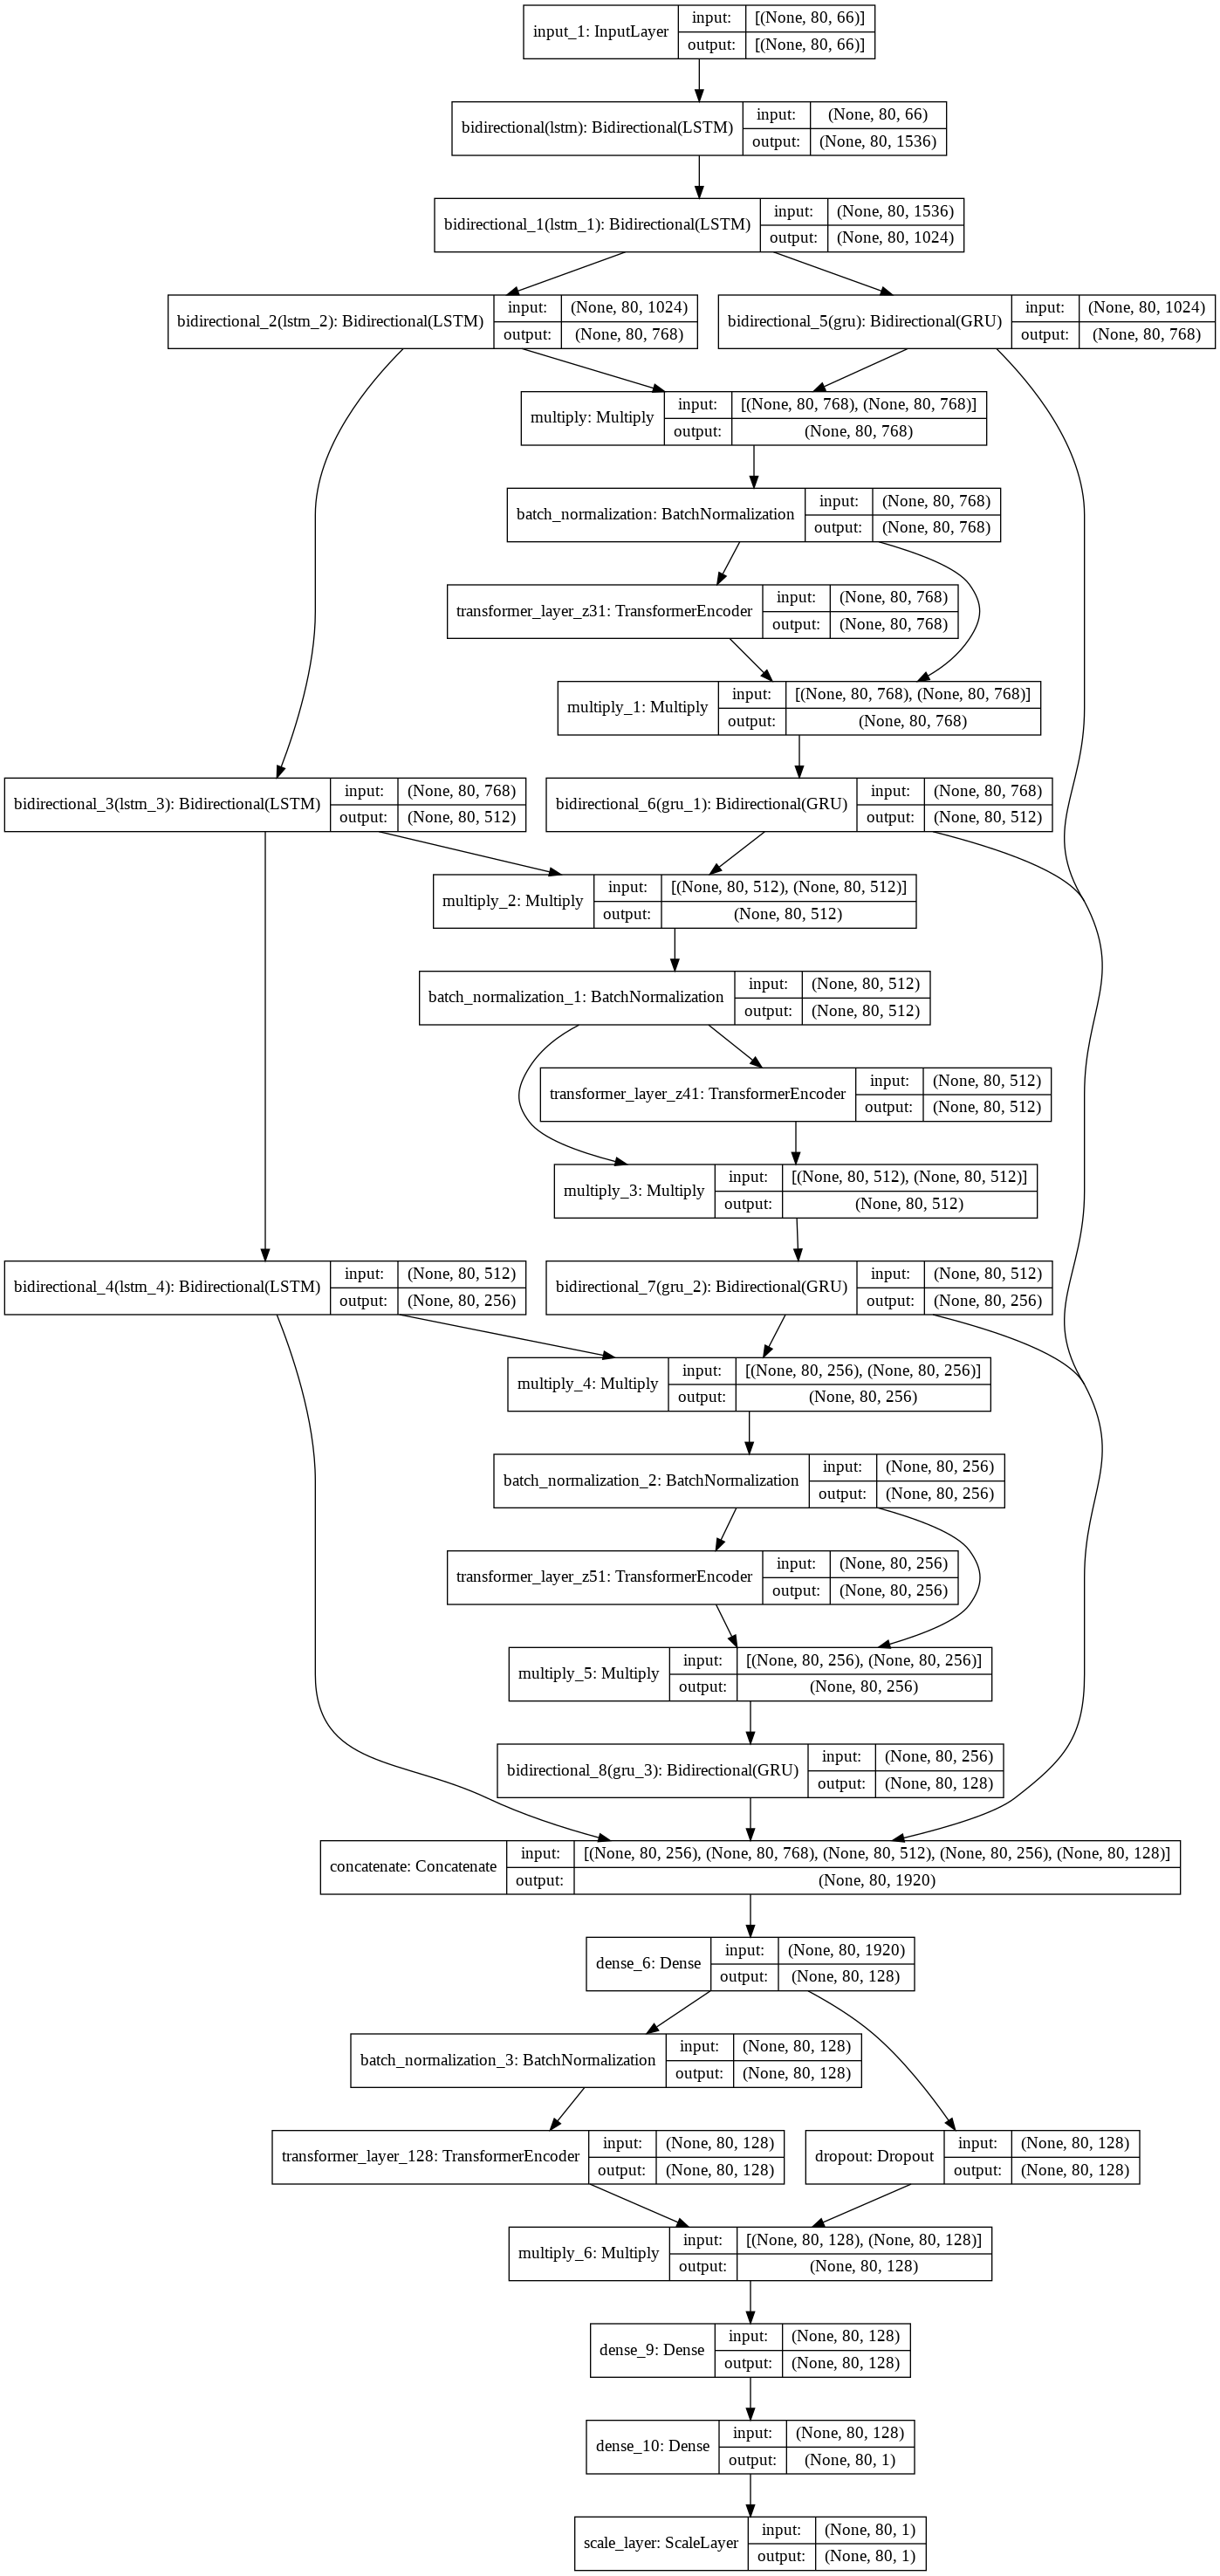

In [21]:
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)


In [22]:
del model
gc.collect()

42532

In [23]:
#reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
    gc.collect()

reset_keras()

In [24]:
train_pred = np.zeros(targets.shape)

In [25]:
#skip_folds = np.arange(1)
skip_folds = []

In [ ]:
with tpu_strategy.scope():
    
    VERBOSE = 2
    EPOCHS = 200
    FOLDS = 7
    if DEBUG:
      EPOCHS = 100
    test_preds = []
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2021)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        if len(test_preds) > fold:
          print(f'Ignore corrent fold {fold+1} as we already predicted test data')

        if DEBUG and fold > 0:
          continue
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        checkpoint_name = f'./model-gpu/Bidirect_LSTM_model_{fold+1}C.h5'
        chk_point = ModelCheckpoint(checkpoint_name,
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50, 
                           verbose=VERBOSE, mode="min", 
                           restore_best_weights=True)
        
        if fold not in skip_folds:
          model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid), 
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    batch_size=BATCH_SIZE, 
                    callbacks=[lr, chk_point, es])
        else:
          print('Load pretrain weight from ', checkpoint_name)
          load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
          try:
            # At loading time, register the custom objects with a `custom_object_scope`:
            custom_objects = {"ScaleLayer": ScaleLayer}
            with tf.keras.utils.custom_object_scope(custom_objects):
                model = load_model(checkpoint_name, options=load_locally)
          except (OSError):
            print('Cannot load pretrain weight from ', checkpoint_name)
            break
                
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        train_pred[test_idx] = y_pred.reshape(-1, 80)
        score = mean_absolute_error(y_true, y_pred)
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        del X_train, X_valid, y_train, y_valid, model
        reset_keras()
        gc.collect()


Epoch 1/200
253/253 - 417s - loss: 1.0071 - val_loss: 0.7044

Epoch 00001: val_loss improved from inf to 0.70444, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
253/253 - 386s - loss: 0.5508 - val_loss: 0.4990

Epoch 00002: val_loss improved from 0.70444 to 0.49897, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 3/200
253/253 - 387s - loss: 0.4791 - val_loss: 0.4183

Epoch 00003: val_loss improved from 0.49897 to 0.41834, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 4/200
253/253 - 386s - loss: 0.4436 - val_loss: 0.4142

Epoch 00004: val_loss improved from 0.41834 to 0.41418, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 5/200
253/253 - 387s - loss: 0.4174 - val_loss: 0.4110

Epoch 00005: val_loss improved from 0.41418 to 0.41097, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 6/200
253/253 - 387s - loss: 0.3870 - val_loss: 0.3655

Epoch 00006: val_loss improved from 0.41097 to 0.36551, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 7/200
253/253 - 387s - loss: 0.3651 - val_loss: 0.3436

Epoch 00007: val_loss improved from 0.36551 to 0.34356, saving model to ./mode

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
253/253 - 387s - loss: 0.5480 - val_loss: 0.6386

Epoch 00002: val_loss did not improve from 0.60225
Epoch 3/200
253/253 - 387s - loss: 0.4919 - val_loss: 0.4096

Epoch 00003: val_loss improved from 0.60225 to 0.40961, saving model to ./model-gpu/Bidirect_LSTM_model_2C.h5
Epoch 4/200
253/253 - 387s - loss: 0.4455 - val_loss: 0.5357

Epoch 00004: val_loss did not improve from 0.40961
Epoch 5/200
253/253 - 387s - loss: 0.4282 - val_loss: 0.3840

Epoch 00005: val_loss improved from 0.40961 to 0.38398, saving model to ./model-gpu/Bidirect_LSTM_model_2C.h5
Epoch 6/200
253/253 - 387s - loss: 0.4023 - val_loss: 0.3973

Epoch 00006: val_loss did not improve from 0.38398
Epoch 7/200
253/253 - 387s - loss: 0.3673 - val_loss: 0.3367

Epoch 00007: val_loss improved from 0.38398 to 0.33668, saving model to ./model-gpu/Bidirect_LSTM_model_2C.h5
Epoch 8/200
253/253 - 387s - loss: 0.3529 - val_loss: 0.3415

Epoch 00008: val_loss did not improve from 0.33668
Epoch 9/200
253/253 - 387s - los

In [ ]:
if not DEBUG:
  train_pred = train_pred.flatten()
  targets = targets.flatten()
  score = mean_absolute_error(targets, train_pred)
  print(f"Train Score: {score}")

## Create submission file

In [ ]:
if not DEBUG:
  submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
  submission["pressure"] = sum(test_preds)/5
  submission.to_csv('submission.csv', index=False)

  # ENSEMBLE FOLDS WITH MEDIAN
  #取中位数
  submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
  submission.to_csv('submission_median.csv', index=False)


  # ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
  submission["pressure"] =\
      np.round( (submission.pressure - pressure_min)/pressure_step ) * pressure_step + pressure_min
  submission.pressure = np.clip(submission.pressure, pressure_min, pressure_max)
  submission.to_csv('submission_median_round.csv', index=False)